## Playing a Season File

### Importing required libraries

In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
from sklearn import datasets
from sklearn.model_selection import train_test_split  
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import copy
from sklearn.linear_model import LogisticRegression
import os
import difflib
import math
import re

### Import Input Files

<b><u> Note: </u></b> Quick dataframe cleaning by dropping "Unnamed" column and any duplicate rows
- Things to specifiy:
        - Year to play the season for 
        - File_path where the modeling file is saved
        - Output file location to save results in jpeg
        - Number of parallel games to be played 
- Then go to cells and click run all to get the results for choices made  based on modeling predictions 

In [214]:
year = "2016"
file_path = r'C:\Users\Public\Modeling'

csv = file_path + r'\modeling_%s.csv' %year
df_modeling = pd.read_csv(csv)
df_modeling = df_modeling.drop(['Unnamed: 0'],axis=1)
df_modeling = df_modeling.drop_duplicates()

df_modeling['DateTime'] = pd.to_datetime(df_modeling['Date'], format='%Y-%m-%d')

output_file_save_location =r'C:\Users\Public\Play_a_season'

num_of_parallel_games = 3



### Function to create a perform logistic regression and output model predictions 

Function outputs:
    - selection_df_list: List of dictionaries containing testing prediction, date, batter, and correct (expected) prediction 
    - testing_scores : List of logistic regression testing data score
    - training_scores : List of logistic regression training data score

In [215]:
def outputLogRegModelPredictions (date_range_to_predict, df_modeling):
    
    testing_scores = []
    training_scores = []   
    selection_df_list=[]
    
    
    for date in date_range_to_predict:
        
        # Creating a deep copy to prevent overwrittig 
        df_specific = copy.deepcopy(df_modeling)[df_modeling['DateTime'] <= date]
        
        columns_to_use_for_modeling = ['Batter', 'Pitcher', 'Position_In_Lineup', 'Difference_Batter_And_Pitcher','Batting_Average','Number_Of_Plate_Appearances', 'ERA']
       
        X_train = df_specific[df_specific['DateTime']< date][columns_to_use_for_modeling]
        X_test_unprocessed = df_specific[df_specific['DateTime'] == date][columns_to_use_for_modeling]
        X_test_unprocessed = X_test_unprocessed.dropna()

        # If there are no factors (column) data that correspond to the date to predict for then move on to the next date
        if X_test_unprocessed.empty:
            continue
        
        X_test, index = createTestingDataFrame(X_test_unprocessed, X_train)
 
        y_train = df_specific[df_specific['DateTime']< date][['Hit']]
        y_test = df_specific[df_specific['DateTime']== date][['Hit']]
        y_test = y_test.drop(index)


        # Performing the logistic regression using a max_iter of 200 to achieve convergence 
        log_reg = LogisticRegression( max_iter = 500)
        
        # Ravel function had to be used to convert column vector to an array for fitting
        log_reg.fit(X_train, y_train.values.ravel())
        
        # Predicting hit(s) and probability of hit(s)
        y_pred = log_reg.predict(X_test)
        y_prob = log_reg.predict_proba(X_test)
        
        
        
        # Creating a dataframe of required values (mentioned in note above)
        temp_selection_df =pd.DataFrame()
        temp_selection_df['Batter'] = X_test['Batter'].to_list()
        temp_selection_df['Prediction_Prob'] = list(y_prob[:,1])
        temp_selection_df['Date'] = [date]*len(X_test['Batter'].to_list())
        temp_selection_df['Correct_Pred'] = y_test['Hit'].to_list()
        temp_selection_df['Batting_Average'] = X_test['Batting_Average'].to_list()
        temp_selection_df['ERA'] = X_test['ERA'].to_list()

        selection_df_list.append(temp_selection_df.sort_values('Prediction_Prob', ascending=False))
        
        
    return selection_df_list, testing_scores, training_scores


### Function to create Testing Dataframe
<b><u> Note: </u></b> The purpose of this is to make sure that there is only data availabe prior to the day to predict for included in testing data.
- So, for the ERA and Batting averges are filled using most recent previous score
- The plate appearnce is an estimated average using formula found online
- The Batter line up position is published before game day

In [216]:
def createTestingDataFrame(X_test_unprocessed, X_train):
    X_test = X_test_unprocessed.drop(['Number_Of_Plate_Appearances', 'Batting_Average', 'ERA'], axis =1)
        
    # Filling in PA with estimations from website cited in report
    dict_avg_appr ={1:4.65,
            2:4.55,
            3:4.43,
            4: 4.33,
            5:4.24,
             6:4.13,
             7:4.01,
             8:3.90,
             9:3.77}
    
    X_test["Number_Of_Plate_Appearances"] = X_test["Position_In_Lineup"].map(dict_avg_appr)

    # Filling in BA for specific player with their most recent previous game BA
    batting_average_in_order_of_player = []
    for i, player in enumerate(X_test['Batter']):
        batting_average_temp_df = X_train[X_train["Batter"] == player]["Batting_Average"]
        if batting_average_temp_df.empty:
            batting_average_temp = np.nan
        else:
            batting_average_temp = batting_average_temp_df.iloc[-1]            
        
        batting_average_in_order_of_player.append(batting_average_temp)
            
    X_test["Batting_Average"] = batting_average_in_order_of_player
    
    # Filling in ERA for specific pitcher with their most recent previous game ERA    
    era_in_order_of_player = []
    for j, pitcher in enumerate(X_test['Pitcher']):
        era_temp_df = X_train[X_train["Pitcher"] == pitcher]['ERA']
        if era_temp_df.empty:
            era = np.nan
        else:
            era = era_temp_df.iloc[-1]            
        
        era_in_order_of_player.append(era)
            
    X_test["ERA"] = era_in_order_of_player
    
    # Remove any rows containing nan and get their index     
    index_ba = X_test['Batting_Average'].index[X_test['Batting_Average'].apply(np.isnan)]
    index_era = X_test['ERA'].index[X_test['ERA'].apply(np.isnan)]
    index_pa = X_test['Number_Of_Plate_Appearances'].index[X_test['Number_Of_Plate_Appearances'].apply(np.isnan)]

    # Combine index using sets to remove duplicates   
    index = list(set(index_ba.to_list() + index_era.to_list()+ index_pa.to_list()))
    
        
    X_test = X_test.dropna()
    return X_test, index

### Function to select players whose chance of getting a hit is above a certain threshold

<b><u> Notes: </u></b> 
- The players are selected from the "selection_df_list" output from the outputLogRegModelPredictions function. 
- This function outputs a single dataframe containing players that meet the threshold ordered by date and then in descending order of probability. The dataframe also has a column where the batter name and correct prediction is indicated for error check.

<b><u> Future Work: </u></b>The commented out code (titled: Inverting Player Id to Player Name) can be used to convert the selected players for the day from their unique id to their names. For this to work, the coder needs to pass in an argument called batter_mapping dictionary which contains the orginal mapping to unique id.
The batter_mapping dictionary can be imported as a csv file.

In [217]:
def getOverThresholdPlayerFromDf(selection_df_list, threshold = 0.8):
    
    # Converting list of dataframes to a single datagrame
    master_df = pd.concat(selection_df_list)
    
    # Inverting Player Id to Player Name
    #Inverting the player number mapping to show the player names
    #inv_map = {v: k for k, v in batter_mapping.items()}
    #master_df = master_df.replace({'Batter': inv_map})
    
    # Making selection above the threshold value
    df_above_threshold = master_df[master_df['Prediction_Prob'] >= threshold]
    
    return df_above_threshold
   

### Functions to get a player to select per day for a whole season based 

#### Function to chose a player for parallel games using the same threshold for all parallel games

In [218]:
def getStreakList (num_of_parallel_games, df_above_threshold):
    start_date = min(df_above_threshold['Date'])
    end_date = max(df_above_threshold['Date'])
    
    nested_list = [[] for num in range(num_of_parallel_games)]

    date_range = pd.date_range(start= start_date , end= end_date )
    date_list_predicted_for = []
    for date in date_range:
        df_specific = df_above_threshold[df_above_threshold['Date'] == date]                
                
        df_specific = df_specific.sort_values('Prediction_Prob', ascending=False)
        date_list_predicted_for.append(date)
        
        # Appending all parallel games as nan since they are all skips if there is no prediction made for specific date
        if (df_specific.empty):
            for n in np.arange(0, num_of_parallel_games):
                nested_list[n].append(np.nan)
                
        # If there are more predictions that number of parallel games then appending predictions for each parallel game
        elif df_specific.shape[0] >= num_of_parallel_games:
            for i, pred_result in enumerate(df_specific['Correct_Pred']):
                if i < num_of_parallel_games:
                    nested_list[i].append(pred_result)
        
        # If there are less predictions that number of parallel games then appending predictions for each parallel 
        # game where prediction exists and then appending nan for skipped games
        elif df_specific.shape[0] < num_of_parallel_games:
            for i, pred_result in enumerate(df_specific['Correct_Pred']):
                nested_list[i].append(pred_result)
            for n in np.arange(i+1, num_of_parallel_games):
                nested_list[n].append(np.nan)
                
    return nested_list, date_list_predicted_for       
            
    
        
        

#### Function to chose a player for parallel games using different threshold for each parallel games

In [219]:
def getStreakListBasedOnDifferentThresholdParallelGames (df_above_threshold):
    start_date = min(df_above_threshold['Date'])
    end_date = max(df_above_threshold['Date'])
    
    num_of_parallel_games = len(df_above_threshold)
    nested_list = [[] for num in range(num_of_parallel_games)]

    date_range = pd.date_range(start= start_date , end= end_date )
    date_list_predicted_for =  [[] for num in range(num_of_parallel_games)]
    
    for date in date_range:
        for j, df in enumerate(df_above_threshold):
            df_specific = df[df['Date'] == date]
            
            if (df_specific.empty):
                continue
                            
            date_list_predicted_for[j].append(date)
            nested_list[j].append(max(df_specific['Correct_Pred']))

            
                
    return nested_list, date_list_predicted_for       
            
    
        
        

### Function to check if one of the parallel games had a correct hit guess

In [220]:
def masterList (nested_list, date_list_predicted_for):
    names = []
    for i in range(len(nested_list)):
        names.append(str(i))
        
    df =  pd.DataFrame()
    for i,lst in enumerate(nested_list):
        df[names[i]]=lst
         
    output = []
    for index, row in df.iterrows():
        if 1 in row.to_list():
            output.append(1)
        else:
            output.append(row[0])
    return output

### Function to create a plot streaks for each parallel game in a season

In [221]:
def calculateLongestStreak (streak_list):
    counter = 0
    streaks = []
    for val in streak_list:
        if val == 0:
            streaks.append(counter)
            counter = 0
        elif val ==1:
            counter +=1
        else:
            continue
    if len(streaks) == 0:
        streaks.append(counter)
    return max(streaks) 

### Function to create a plot of model 

In [222]:
def createStreakPlot (nested_list, date_list_predicted_for, year, plotType):
    plots = []
    i=0
    for streak_list in nested_list:
        max_streak = calculateLongestStreak(streak_list)
        unique_name = "Case "+ str(i+1) + ': Longest Streak = ' + str(max_streak)
        plt.figure()
        plt.plot(date_list_predicted_for, streak_list)
        plt.xlabel('Dates', fontsize=13)
        plt.ylabel('Prediction Correctness', fontsize=13)
        plt.title('%s Season Streak Check %s' %(year, unique_name), fontsize =15)
        file_save_full_path = output_file_save_location + r'\%s\streakPlot_%s parallel_picks_%s.jpeg' %(year, i, plotType)
        plt.savefig(file_save_full_path, bbox_inches='tight',dpi=1000)

        i+=1

 

### Create input parameters for modeling  and run modeling function

In [223]:
start_date_to_predict = "%s-05-05" %year
end_date_to_predict = "%s-10-30" %year
date_range_to_predict = pd.date_range(start= start_date_to_predict, end= end_date_to_predict)

df_modeling_selected = df_modeling[['Batter', 'Pitcher', 'Position_In_Lineup', 'Difference_Batter_And_Pitcher','Batting_Average','Number_Of_Plate_Appearances', 'ERA','DateTime', 'Hit']]

selection_df_list, testing_scores, training_scores = outputLogRegModelPredictions (date_range_to_predict, df_modeling_selected)    

### Getting Dataframe with Predictions above specified threshold and Selecting player for each parallel game
- Threshold is chosen to be 0.9

In [228]:
df_above_threshold = getOverThresholdPlayerFromDf(selection_df_list, 0.9)
nested_list, date_list_predicted_for = getStreakList (num_of_parallel_games, df_above_threshold)

### Combining Predictions for all parallel games to see if atlest one the top X players is a correct prediction 57 days in a row 
- X  here refers to number of parallel games specified
- The 57 days in a row excludes (and not penalize) skipped days
- The streak is broken if all the X picks are incorrect predictions

In [ ]:
combined_game = masterList(nested_list, date_list_predicted_for)

### Plotting the results for each parallel game and the single combined game

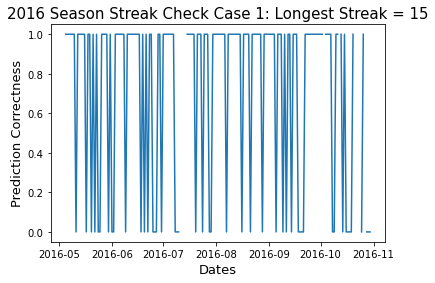

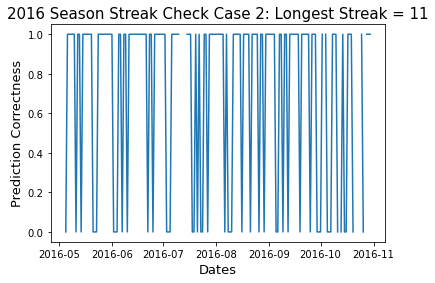

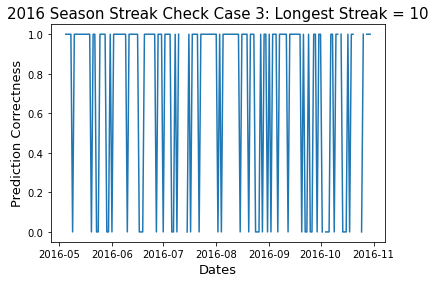

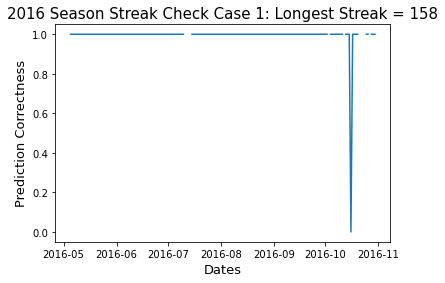

In [225]:
createStreakPlot (nested_list, date_list_predicted_for, year, "Parallel Games" )
createStreakPlot ([combined_game], date_list_predicted_for, year, "Combining Parallel Games")